In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from umap import UMAP
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_theme(style="white", palette="muted")

In [2]:
# Load data
books = pd.read_pickle('Pickle/books.pkl')

In [3]:
# Create embedding matrix
embedding_matrix = np.vstack(books['embeddings'].values)

In [4]:
scaler = StandardScaler() 
scaled_embeddings = scaler.fit_transform(embedding_matrix)

In [5]:
pca = PCA(n_components=45, random_state=42)
pca_embeddings = pca.fit_transform(scaled_embeddings)

In [6]:
train_indices, test_indices = train_test_split(np.arange(pca_embeddings.shape[0]), test_size=0.2, random_state=42)
train_embeddings, test_embeddings = pca_embeddings[train_indices], pca_embeddings[test_indices]

In [ ]:
umap_model = UMAP(n_components=2, random_state=42) 
umap_train_embeddings = umap_model.fit_transform(train_embeddings) 
umap_test_embeddings = umap_model.transform(test_embeddings)

c:\Users\maddy\anaconda3\envs\goodreads\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1, random_state=42) 
outliers = iso_forest.fit_predict(umap_train_embeddings) 
clean_train_embeddings = umap_train_embeddings[outliers == 1]

In [ ]:
# Apply KMeans clustering on training set
n_clusters = 16
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Increased n_init
clean_train_clusters = kmeans.fit_predict(clean_train_embeddings)

In [ ]:
train_clusters = np.full(umap_train_embeddings.shape[0], -1) 
train_clusters[outliers == 1] = clean_train_clusters

In [ ]:
test_clusters = kmeans.predict(umap_test_embeddings)

In [ ]:
# Add cluster labels to the books dataframe for the training set
train_books = books.iloc[train_indices].copy()
train_books['cluster'] = train_clusters

In [ ]:
# Add cluster labels to the books dataframe for the testing set
test_books = books.iloc[test_indices].copy()
test_books['cluster'] = test_clusters

In [ ]:
# Function to get recommendations based on clusters
def get_recommendations_by_cluster(book_id, books_df, normalized_embeddings, top_n=5):
    if book_id not in books_df['book_id'].values:
        print(f"Book ID {book_id} not found in the books dataframe.")
        return pd.DataFrame(columns=['title', 'authors', 'book_id'])
    
    book_cluster = books_df[books_df['book_id'] == book_id]['cluster'].values[0]
    cluster_books = books_df[books_df['cluster'] == book_cluster]
    
    if len(cluster_books) <= top_n:
        return cluster_books[['title', 'authors', 'book_id']]
    
    # Calculate similarity within the cluster
    book_idx = cluster_books[cluster_books['book_id'] == book_id].index[0]
    cluster_embedding_matrix = normalized_embeddings[cluster_books.index]
    sim_scores = cosine_similarity(cluster_embedding_matrix[book_idx].reshape(1, -1), cluster_embedding_matrix).flatten()
    sim_scores_indices = sim_scores.argsort()[::-1]
    
    top_book_indices = sim_scores_indices[1:top_n+1]  # Exclude the input book itself
    top_books = cluster_books.iloc[top_book_indices]
    
    return top_books[['title', 'authors', 'book_id']]


In [ ]:
books['book_id']

In [ ]:
get_recommendations_by_cluster(1, train_books, clean_train_embeddings, top_n=5)

In [ ]:
# Calculate silhouette score for the testing set
silhouette_avg_test = silhouette_score(umap_test_embeddings, test_clusters)
print(f'Silhouette Score (Test): {silhouette_avg_test}')


Silhouette Score (Test): 0.36500313878059387


In [ ]:
# Calculate intra-cluster distance
def intra_cluster_distance(embeddings, clusters, centroids):
    total_distance = 0
    for i, label in enumerate(clusters):
        if label != -1:  # Exclude outliers
            cluster_center = centroids[label]
            distance = np.linalg.norm(embeddings[i] - cluster_center)
            total_distance += distance
    return total_distance / np.sum(clusters != -1)

# Calculate intra-cluster distance for cleaned data
intra_distance_test = intra_cluster_distance(umap_test_embeddings, test_clusters, kmeans.cluster_centers_)
print(f'Intra-Cluster Distance (Test): {intra_distance_test}')


Intra-Cluster Distance (Test): 0.7719643934887968


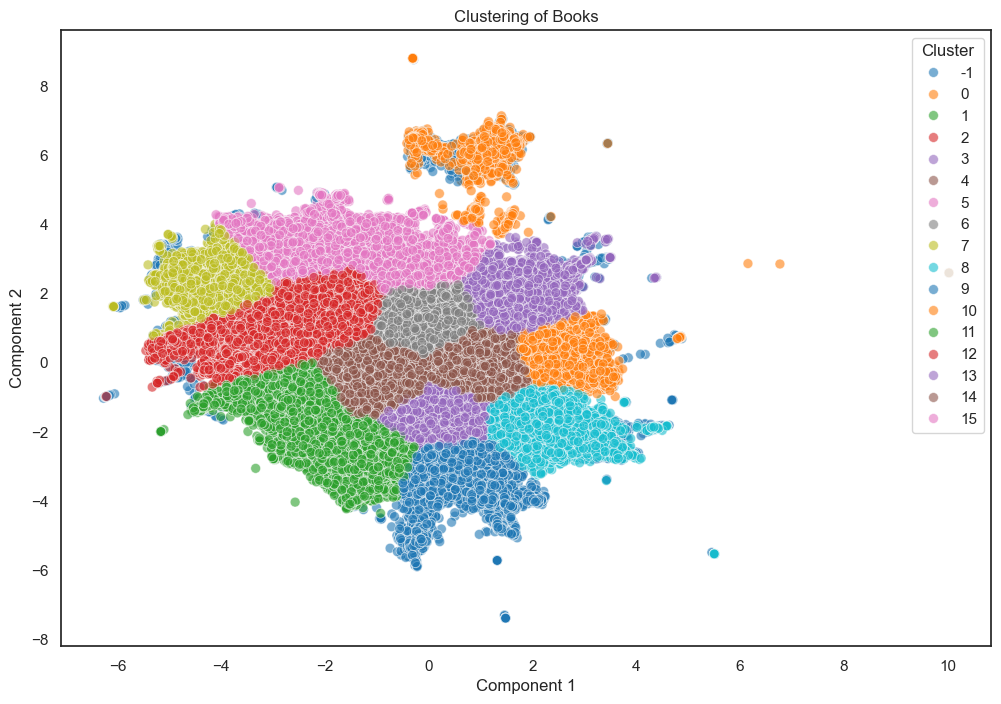

In [ ]:
combined_umap_embeddings = np.vstack((umap_train_embeddings, umap_test_embeddings))

# Concatenate train and test clusters
combined_clusters = np.concatenate((train_clusters, test_clusters))

# Combine embeddings and clusters for plotting
plot_df = pd.DataFrame(combined_umap_embeddings, columns=['Component 1', 'Component 2'])
plot_df['cluster'] = combined_clusters

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='Component 1', y='Component 2', hue='cluster', palette='tab10', s=50, alpha=0.6, edgecolor='w')
plt.title('Clustering of Books')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.show()
